In [ ]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import tensorflow as tf
import os
import tensorflow.python.ops.numpy_ops.np_config as np_config
np_config.enable_numpy_behavior()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# print(os.getcwd())
# save_dir = os.path.join(os.getcwd(), 'saved_models')

Mounted at /content/gdrive
/content


In [ ]:

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

#function to read the data from downloaded batch data from
def read_CIFAR10_data(path):
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    for i in range(1,6):
        train_batch_path = path+"/data_batch_" + str(i)
        batch_data = unpickle(train_batch_path)
        x_train.append(batch_data['data'])
        y_train.append(batch_data['labels'])
        
    x_train = np.reshape(np.array(x_train).reshape(50000,3072), (50000,3,32,32)).transpose(0, 2, 3, 1)
    y_train = np.array(y_train).reshape(-1,1)
    
    test_path = path + "/test_batch"
    test_data = unpickle(test_path)
    x_test.append(test_data['data'])
    y_test.append(test_data['labels'])
    x_test = np.reshape(np.array(x_test), (10000, 3, 32, 32)).transpose(0, 2, 3, 1)
    y_test = np.array(y_test).reshape(-1,1)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
#reading dataset either we can use read_CIFAR10_data function with the path or inbuilt load_data method
path = "cifar-10-python/cifar-10-batches-py"
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

#Central cropping the image to 75%of it's normal extents
x_train = tf.image.central_crop(x_train,0.75)
x_test = tf.image.central_crop(x_test,0.75)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

170508288/170498071 [==============================] - 11s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
x_train shape: (50000, 24, 24, 3)
x_test shape: (10000, 24, 24, 3)


In [ ]:
!nvidia-smi

Tue Jun 22 10:28:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    57W / 149W |    122MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
np.unique(y_train, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [ ]:
'''set type of bias '''
# diff_gaussian_per_class :  add gaussian color bias with different mean for each class
# same_gaussian_per_class :  add gaussian color bias with different mean for each class
# random_samples : randomly select some samples and assign a common label
# percent_samples_per_class : randomly select same percentage of points from each class and mislabel them
# remove_one_class : remove some percentage of data points from pne of the classes
# swap_labels : for any 2 classes swap their labels

biases = ["None","diff_gaussian_per_class","same_gaussian_per_class","random_samples","percent_samples_per_class","remove_one_class", "swap_labels"]
bias_type = biases[5]

batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)



x_train shape: (50000, 24, 24, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [ ]:
import random
import copy
#Mislabelling some % of training data
if(bias_type == "random_samples"):
  assigned_label = random.sample(range(10),1)
  mislabel_percent = 20
  num_mislabels = mislabel_percent * 500
  mislabeled_indices = random.sample(range(50000),10000)
  for i in mislabeled_indices:
      y_train[i] = assigned_label
  print(assigned_label,mislabeled_indices)

#percent_samples_per_class
if(bias_type == "percent_samples_per_class"):
  #print(random.sample(range(5),2))
  y_train1 = copy.copy(y_train)
  error_percent = 20
  for i in range(10):
    indices = np.where(y_train1==i)[0]
    print(indices)
    samples = (error_percent * 5000)/100
    mislabeled_indices = random.sample(range(5000),int(samples))
    for j in mislabeled_indices:
      assigned_label = random.sample(range(10),1)
      while(assigned_label[0]==i):
        assigned_label = random.sample(range(10),1)
      y_train[indices[j]] = assigned_label[0]

## Add gaussian color bias to the training data
input_shape = x_train.shape[1:] #(32,32,3)
def add_gaussian_color(data,indices,mean,variance):
    sigma = variance**0.5
    s = np.random.normal(mean, sigma, input_shape)
    s = s.reshape(input_shape)
    data[indices,] = data[indices,] + s
    return data

if(bias_type == "diff_gaussian_per_class"): 
  labels = np.arange(10) #[0,1,2,3,4,5,6,7,8,9]
  variance =  0.02
  mean_colors = [0.1, 0.18, 0.26, 0.34, 0.42, 0.50, 0.58, 0.66, 0.74, 0.82]
  #mean_color = 0.2
  for i in range(10):
      indices = np.where(y_train==labels[i])[0]
      x_train = add_gaussian_color(x_train,indices,mean_colors[i],variance)

if(bias_type == "same_gaussian_per_class"): 
  labels = np.arange(10) #[0,1,2,3,4,5,6,7,8,9]
  variance =  0.02
  mean_color = 0.2
  for i in range(10):
      indices = np.where(y_train==labels[i])[0]
      x_train = add_gaussian_color(x_train,indices,mean_colors[i],variance)

bias_type == "remove_one_class"
if(bias_type == "remove_one_class"):
  label = 1 #the class whose training data to be removed
  percent_remove = 20
  samples = ((100-percent_remove) * 5000)/100
  indices = np.where(y_train==label)[0]
  print(indices.shape)
  rem_indices = random.sample(range(5000),int(samples))
  indices = np.delete(indices, rem_indices)
  print(indices.shape)
  x_train = np.delete(x_train,indices,axis=0)
  y_train = np.delete(y_train,indices)

if(bias_type == "swap_labels"):
  labels = random.sample(range(10),2) #the class whose training data to be removed
  print("label swapped are:",labels)
  indices0 = np.where(y_train==labels[0])[0]
  indices1 = np.where(y_train==labels[1])[0]
  
  y_train[indices0] = labels[1]
  y_train[indices1] = labels[0]


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

np.unique(y_train, return_counts = True)

from tensorflow.keras.utils import to_categorical
# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

(5000,)
(1000,)
x_train shape: (49000, 24, 24, 3)
49000 train samples
10000 test samples
y_train shape: (49000,)


In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        w = x.get_weights()
        x = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer=w,
                  kernel_regularizer=l2(1e-4))(x)
    return x

In [ ]:

def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(6)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy')
]
model = resnet_v1(input_shape=input_shape, depth=14)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=METRICS)
model.summary()

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 24, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 24, 24, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 24, 24, 16)   0           batch_normalization[0][0]        
________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), '/gdrive/MyDrive/Colab Notebooks/saved_models')
model_name = 'cifar10_resnet20_biased5.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
print(filepath)
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

/gdrive/MyDrive/Colab Notebooks/saved_models/cifar10_resnet20_biased5.h5


In [ ]:
print('Not using data augmentation.')
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=callbacks)

from matplotlib import pyplot as plt


Not using data augmentation.
Epoch 1/200
Learning rate:  0.001
383/383 [==============================] - 68s 49ms/step - loss: 1.8835 - accuracy: 0.3639 - val_loss: 1.6207 - val_accuracy: 0.4696
Epoch 2/200
Learning rate:  0.001
383/383 [==============================] - 17s 43ms/step - loss: 1.2797 - accuracy: 0.5809 - val_loss: 1.2524 - val_accuracy: 0.5936
Epoch 3/200
Learning rate:  0.001
383/383 [==============================] - 17s 43ms/step - loss: 1.0924 - accuracy: 0.6517 - val_loss: 1.1359 - val_accuracy: 0.6387
Epoch 4/200
Learning rate:  0.001
383/383 [==============================] - 17s 43ms/step - loss: 0.9655 - accuracy: 0.7003 - val_loss: 1.1324 - val_accuracy: 0.6447
Epoch 5/200
Learning rate:  0.001
383/383 [==============================] - 17s 43ms/step - loss: 0.8472 - accuracy: 0.7423 - val_loss: 1.3403 - val_accuracy: 0.5938
Epoch 6/200
Learning rate:  0.001
383/383 [==============================] - 17s 43ms/step - loss: 0.7787 - accuracy: 0.7665 - val_loss:

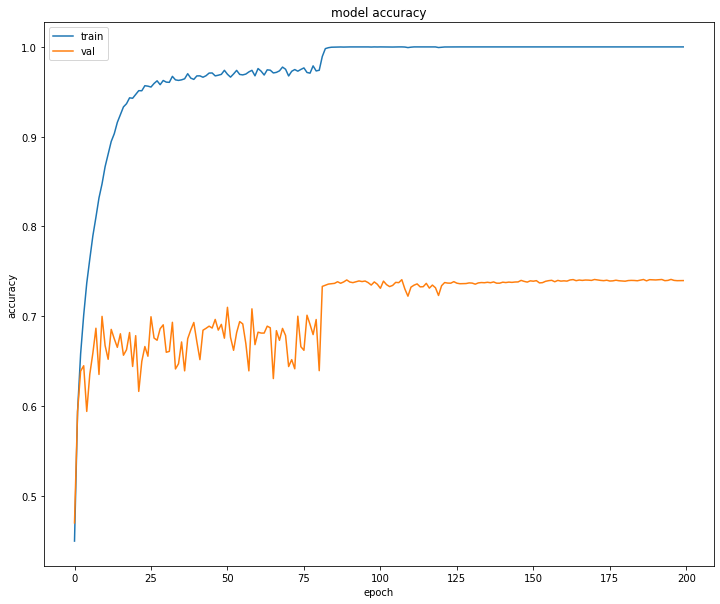

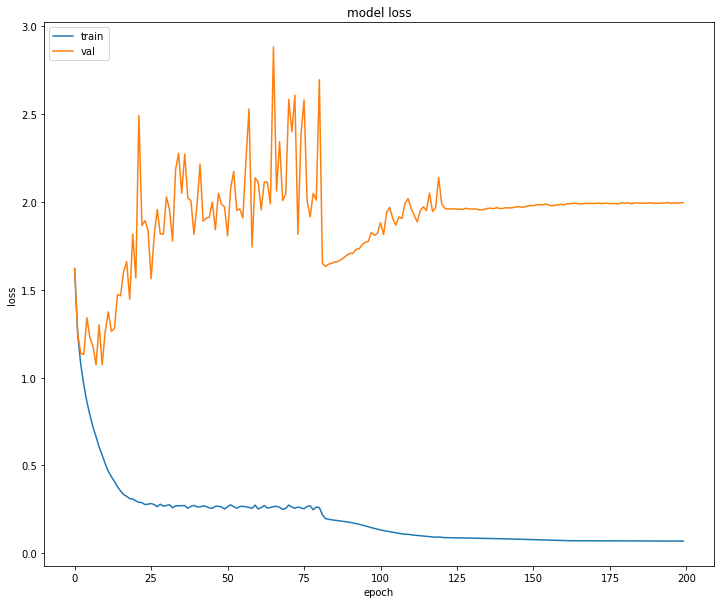

[3 8 8 ... 5 1 7]
0


TypeError: ignored

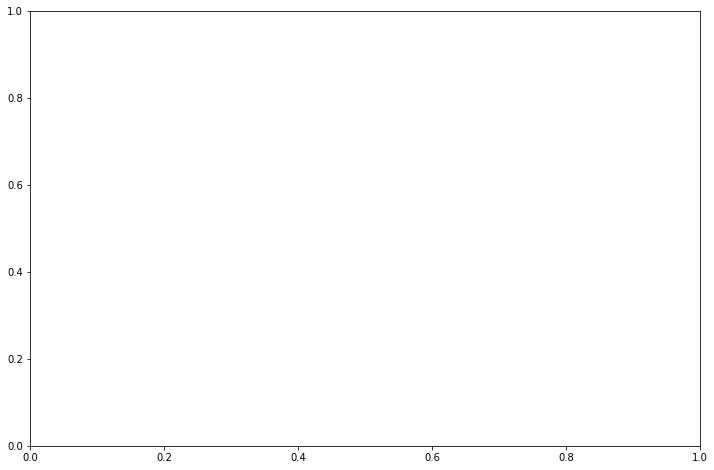

In [ ]:
#Parameters Sharing in Residual Neural Networks
from matplotlib import pyplot as plt
import matplotlib as mpl
import sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

path = "cifar-10-python/cifar-10-batches-py"
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# print('x_train shape:', x_train.shape)
# print(x_train.shape[0], 'train samples')
# print(x_test.shape[0], 'test samples')
# print('y_train shape:', y_train.shape)

#Central cropping the image to 75%of it's normal extents
x_train = tf.image.central_crop(x_train,0.75)
x_test = tf.image.central_crop(x_test,0.75)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# scores = model.evaluate(x_test, y_test, verbose=1)
# print('Test loss:', scores[0])
# print('Test accuracy:', scores[1])

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.figsize'] = (12, 10)

target= ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# y_pred = model.predict(x_train)
# y_pred = y_pred.argmax(axis=-1)
# y_train = y_train.argmax(axis=-1)
# print('ROC AUC score for training data :', multiclass_roc_auc_score(y_train, y_pred))

# c_ax.legend()
# c_ax.set_xlabel('False Positive Rate')
# c_ax.set_ylabel('True Positive Rate')
# plt.show()

y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=-1)
print(y_pred)
y_test = y_test.argmax(axis=-1)
print(y_test)
print('ROC AUC score for test data :', multiclass_roc_auc_score(y_test, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()
